In [1]:
import pandas as pd
import pickle
from tqdm import tqdm
from src.data.hex_utils import *

import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import contextily as ctx
import numpy as np
from pyproj import Transformer
import datetime
import matplotlib.colors as colors

In [ ]:
def split_trajectories(df, distance_col="dist", threshold=200):
    # Create a new column to identify splits
    df["split"] = df[distance_col] > threshold

    # Create trajectory groups
    df["t_group"] = df.groupby("t_idx")["split"].cumsum()

    # Combine original trajectory_id with the new group
    df["t_idx"] = df.groupby(["t_idx", "t_group"]).ngroup()

    # Drop intermediate columns
    df = df.drop(columns=["split", "t_group"])

    return df

In [2]:
crs1 = "epsg:4326"
crs2 = "epsg:3857"
limits = np.array([[116.1, 39.7], [116.7, 40.1]])
patch = np.array([[116.4, 39.9], [116.5, 39.95]])
max_date = datetime.datetime(2007, 9, 1)
n_rows = 100

transformer = Transformer.from_crs(crs1, crs2)

with open("../data/processed/geolife.pkl", "rb") as f:
    gdf = pickle.load(f)

In [3]:
tmp = []
for t_idx, tdf in gdf.groupby("t_idx"):
    traj_start = tdf["datetime"].iloc[0]
    tdf["sub_traj"] = (tdf["datetime"] - traj_start) // datetime.timedelta(hours=3)
    tmp.append(tdf)
tdf = pd.concat(tmp)
tdf = tdf.sort_values(by=["user", "datetime"])
gdf["t_idx"] = tdf.groupby(["t_idx", "sub_traj"]).ngroup()

In [4]:
gdf['month'] = gdf['datetime'].dt.month
gdf['year'] = gdf['datetime'].dt.year
gdf['month_since_start'] = (gdf['year'] - 2007) * 12 + gdf['month'] - 4
gdf = gdf[gdf['month_since_start'] >= 0]
gdf['quarter_since_start'] = gdf['month_since_start'] // 4
gdf['year_since_start'] = gdf['quarter_since_start'] // 4

In [85]:
# Get all unique users and time windows
all_users = gdf["user"].unique()
all_time_windows = gdf["quarter_since_start"].unique()

# Create a cartesian product of users and time windows
all_combinations = pd.MultiIndex.from_product(
    [all_time_windows, all_users], names=["quarter_since_start", "user"]
).to_frame(index=False)

# Calculate user activity
user_activity = (
    gdf.groupby(["quarter_since_start", "user"])["t_idx"]
    .nunique()
    .to_frame()
    .reset_index()
)
user_activity = user_activity.rename(columns={"t_idx": "n_trajectories"})

# Merge the complete user-time grid with user activity data
user_activity = all_combinations.merge(
    user_activity, on=["quarter_since_start", "user"], how="left"
)

# Fill missing values with 0
user_activity["n_trajectories"] = user_activity["n_trajectories"].fillna(0)
user_activity = user_activity.sort_values(by='quarter_since_start')
most_active_users = user_activity.groupby('user')['n_trajectories'].sum().nlargest(5).index
user_activity['rel_activity'] = user_activity['n_trajectories'] / user_activity.groupby('quarter_since_start')['n_trajectories'].transform('sum')

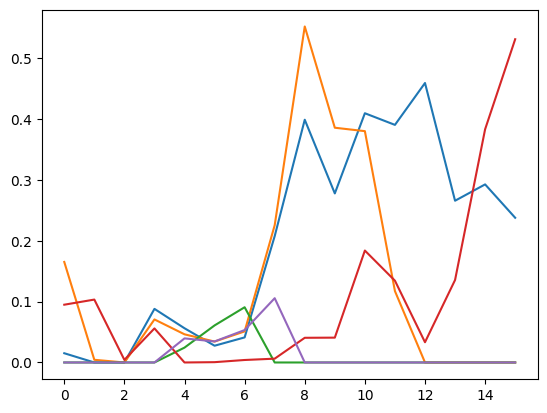

In [7]:
# Visualize user distribution over time
fig, ax = plt.subplots()
for user in most_active_users: 
    data_user = user_activity[user_activity['user'] == user]
    ax.plot(data_user['quarter_since_start'], data_user['rel_activity'])

In [91]:
# Get all unique users and time windows
all_users = gdf["user"].unique()
all_time_windows = gdf["year_since_start"].unique()

# Create a cartesian product of users and time windows
all_combinations = pd.MultiIndex.from_product(
    [all_time_windows, all_users], names=["year_since_start", "user"]
).to_frame(index=False)

# Calculate user activity
user_activity = (
    gdf.groupby(["year_since_start", "user"])["t_idx"]
    .nunique()
    .to_frame()
    .reset_index()
)
user_activity = user_activity.rename(columns={"t_idx": "n_trajectories"})

# Merge the complete user-time grid with user activity data
user_activity = all_combinations.merge(
    user_activity, on=["year_since_start", "user"], how="left"
)

# Fill missing values with 0
user_activity["n_trajectories"] = user_activity["n_trajectories"].fillna(0)
user_activity = user_activity.sort_values(by='year_since_start')

In [103]:
from scipy.stats import chi2_contingency

# Group by user and check if all years have n_trajectories > 0
users_with_trajectories = user_activity.groupby("user")["n_trajectories"].apply(
    lambda x: (x > 0).all()
)

# Filter users with trajectories > 0 for all years
valid_users = users_with_trajectories[users_with_trajectories].index

test_activity = user_activity[user_activity["user"].isin(valid_users)]

# Run Chi-Squared test on user distribution
results = []
years = test_activity["year_since_start"].unique()
for y_before in years:
    row = []
    for y_after in years:
        act_before = test_activity[test_activity["year_since_start"] == y_before]
        act_after = test_activity[test_activity["year_since_start"] == y_after]

        # Make contingency table
        conting = np.stack([act_before["n_trajectories"], act_after["n_trajectories"]])

        # Get test p-value
        res = chi2_contingency(conting)
        row.append(res.pvalue)

    results.append(row)

In [106]:
df_chi_users = pd.DataFrame(data=results, columns=years)
df_chi_users.round(4)

,0,1,2,3
0,1.0000,0.0,0.0,0.0008
1,0.0000,1.0,0.0,0.0000
2,0.0000,0.0,1.0,0.0000
3,0.0008,0.0,0.0,1.0000


In [8]:
# Visualize drift for user 

mean_user_locs = gdf.groupby(['user', "quarter_since_start"])[['lon', 'lat']].mean().reset_index()
mean_user_locs

,user,quarter_since_start,lon,lat
0,0,4,116.315240,39.996876
1,0,5,116.321426,40.002443
2,0,6,116.339680,39.987186
3,1,4,116.311395,39.999538
4,1,5,116.335391,39.989128
...,...,...,...,...
372,177,7,116.362733,39.951873
373,178,8,116.331890,39.977423
374,179,4,116.318012,40.032970
375,180,6,116.559375,40.051766


In [9]:
# Find users with significant location drift
mean_user_locs = gpd.GeoDataFrame(data=mean_user_locs, geometry=gpd.points_from_xy(mean_user_locs['lon'], mean_user_locs['lat']), crs=crs1)
mean_user_locs = mean_user_locs.to_crs(crs2)
tmp = []
for user, dfu in mean_user_locs.groupby('user'):
    dfu['dist'] = dfu['geometry'].distance(dfu['geometry'].shift())
    tmp.append(dfu)
mean_user_locs = pd.concat(tmp)

In [10]:
mean_user_locs.loc[mean_user_locs['dist'].nlargest(10).index]

,user,quarter_since_start,lon,lat,geometry,dist
164,82,4,116.549802,40.052982,POINT (12974264.627 4873644.533),28823.528354
89,43,6,116.542633,39.874577,POINT (12973466.525 4847732.877),27514.080437
86,42,5,116.362081,39.834419,POINT (12953367.652 4841909.533),23779.313235
234,115,1,116.267221,39.992348,POINT (12942807.815 4864830.377),21201.074935
235,115,3,116.445183,39.964940,POINT (12962618.422 4860848.712),20206.776025
165,82,5,116.377128,40.039696,POINT (12955042.621 4871712.47),19318.861323
25,10,3,116.371934,39.896931,POINT (12954464.488 4850975.902),18420.826510
24,10,2,116.324720,39.775147,POINT (12949208.597 4833320.805),15402.397380
127,63,11,116.347576,39.954465,POINT (12951752.903 4859327.492),14844.547953
337,163,5,116.487350,40.000281,POINT (12967312.436 4865983.054),13172.222390


In [12]:
lon, lat = transformer.transform(gdf["lat"], gdf["lon"])
gdf["lon"] = lon
gdf["lat"] = lat
gdf = split_trajectories(gdf, threshold=4000)

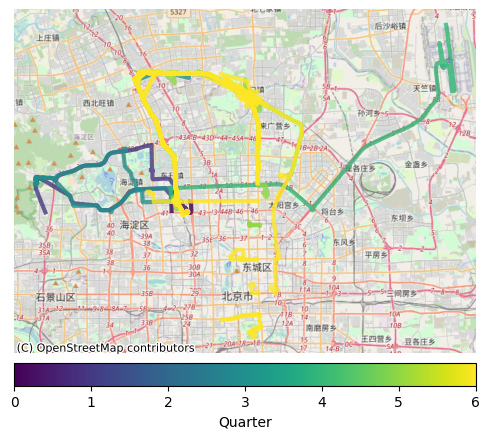

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), sharex=True, sharey=True)
dfp = gdf[gdf['user'] == 82]

# Define the colormap
cmap = plt.cm.viridis  # You can change this to other colormaps like 'plasma', 'inferno', etc.
norm = colors.Normalize(vmin=dfp['quarter_since_start'].min(), vmax=dfp['quarter_since_start'].max())

for quarter, dfq in dfp.groupby("quarter_since_start"):
    for tidx, dft in dfq.groupby('t_idx'):
        color_key = dft['quarter_since_start'].iloc[0]  # Assuming all rows in dft have the same 'quarter_since_start'
        color = cmap(norm(color_key))  # Normalize and map the color

        ax.plot(
            dft["lon"],
            dft["lat"],
            markersize=0,
            color=color,
            linewidth=3,
            alpha=0.8
        )

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Set a dummy array for the ScalarMappable
cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', pad=0.02)
cbar.set_label('Quarter')  # Label for the colorbar

# Add the OpenStreetMap basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=11)

ax.set_aspect("equal")
ax.axis("off")
plt.tight_layout()
plt.show()

In [14]:
lonlat = gdf[['lon', 'lat']].values
qr = coords_to_hex(lonlat, hex_size=1000, coord_offset=lonlat.min(axis=0))
gdf['q'] = qr[:, 0]
gdf['r'] = qr[:, 1]

all_combinations = pd.MultiIndex.from_product(
    [gdf["q"].unique(), gdf["r"].unique(), gdf["quarter_since_start"].unique()],
    names=["q", "r", "quarter_since_start"],
).to_frame(index=False)

vis_v_time = gdf.groupby(["q", "r", "quarter_since_start"]).size().to_frame()
vis_v_time = all_combinations.merge(
    vis_v_time, how="left", on=["q", "r", "quarter_since_start"]
)

In [15]:
vis_v_time = vis_v_time.rename(columns={0: "n_visits"})
vis_v_time["n_visits"] = vis_v_time["n_visits"].fillna(0)
vis_v_time

,q,r,quarter_since_start,n_visits
0,16,18,4,75682.0
1,16,18,5,142698.0
2,16,18,6,105147.0
3,16,18,1,536.0
4,16,18,2,2465.0
...,...,...,...,...
41755,0,36,7,0.0
41756,0,36,11,0.0
41757,0,36,8,0.0
41758,0,36,12,0.0


In [16]:
tmp = []
for qr, dfqr in vis_v_time.groupby(["q", "r"]):
    mean = dfqr["n_visits"].mean()
    dfqr['mean_visits'] = mean
    dfqr["n_visit_diff"] = (dfqr["n_visits"] - mean) / mean
    tmp.append(dfqr)
vis_v_time = pd.concat(tmp)
vis_v_time.loc[vis_v_time[vis_v_time['mean_visits'] > 10000]["n_visit_diff"].nlargest(10).index]

,q,r,quarter_since_start,n_visits,mean_visits,n_visit_diff
6677,19,17,3,110831.0,13019.1250,7.512938
1105,15,17,5,116621.0,14718.1875,6.923598
2818,17,19,6,189111.0,32962.6250,4.737134
1,16,18,5,142698.0,25188.4375,4.665218
9424,24,13,4,113513.0,20475.0000,4.543980
7601,18,17,5,109220.0,20050.6250,4.447212
2785,17,18,5,216292.0,40636.9375,4.322547
34,16,19,6,55807.0,11295.0625,3.940831
18,16,20,6,179862.0,36448.2500,3.934723
960,15,19,4,88227.0,18023.8750,3.895007


In [50]:
center = hex_to_coords(
    np.array([24, 13]), hex_size=1000, coord_offset=lonlat.min(axis=0)
)
lonstep, latstep = 4000, 4000
patch = np.array(
    [
        [center[0] - lonstep, center[0] + lonstep],
        [center[1] - latstep, center[1] + latstep],
    ]
)
dfp = gdf[
    (gdf["lon"] > center[0] - lonstep)
    & (gdf["lon"] <= center[0] + lonstep)
    & (gdf["lat"] > center[1] - latstep)
    & (gdf["lat"] <= center[1] + latstep)
].copy()

dfp = split_trajectories(dfp, threshold=1000)
dfp = dfp[dfp['quarter_since_start'] > 2]
dfp = dfp.reset_index()

In [45]:
dfp = gpd.GeoDataFrame(data=dfp, geometry=gpd.points_from_xy(dfp['lon'], dfp['lat']))
tmp = []
for tidx, dft in dfp.groupby('t_idx'):
    dft['dist'] = dft['geometry'].distance(dft['geometry'].shift())
    tmp.append(dft)
dfp = pd.concat(tmp)

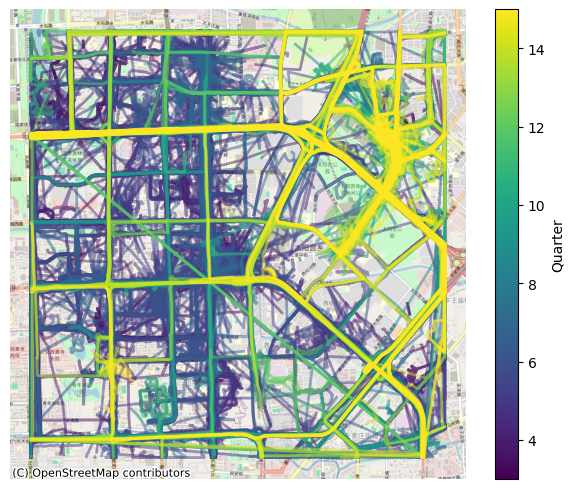

In [51]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import contextily as ctx  # Assuming you're using this for basemaps

fig, ax = plt.subplots(1, 1, figsize=(5, 6), sharex=True, sharey=True)

# Define the colormap
cmap = plt.cm.viridis  # You can change this to other colormaps like 'plasma', 'inferno', etc.
norm = colors.Normalize(vmin=dfp['quarter_since_start'].min(), vmax=dfp['quarter_since_start'].max())

for quarter, dfq in dfp.groupby("quarter_since_start"):

    for tidx, dft in dfq.groupby('t_idx'):
        color_key = dft['quarter_since_start'].iloc[0]  # Assuming all rows in dft have the same 'quarter_since_start'
        color = cmap(norm(color_key))  # Normalize and map the color

        ax.plot(
            dft["lon"],
            dft["lat"],
            markersize=0,
            color=color,
            linewidth=2,
            alpha=0.5
        )

# Add the OpenStreetMap basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Set a dummy array for the ScalarMappable
cbar = fig.colorbar(sm, ax=ax, orientation='horizontal')
cbar.set_label('Quarter')  # Label for the colorbar

ax.axis("off")
plt.tight_layout()
plt.show()
